# RNN Classifier con PyTorch Lightning
## Trabajo Computacional 2

Este notebook implementa un clasificador RNN para predecir el origen de nombres utilizando PyTorch Lightning.

### Objetivos
- Implementar un modelo RNN, LSTM y GRU para la tarea de clasificación usando PyTorch Lightning
- Modularizar el código en componentes reutilizables:
  - `model.py`: Definición del modelo RNN
  - `datamodule.py`: Manejo de datos y preprocessing
  - `train.py`: Loop de entrenamiento y evaluación

## Instalación y configuración

Primero instalamos las dependencias necesarias e importamos las bibliotecas.

In [1]:
# Instalar PyTorch Lightning si no está instalado
# !pip install lightning

In [2]:
import os
import sys
import torch
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import numpy as np
import importlib

# Importar módulos personalizados
from utils.model import RNNClassifier
from utils.datamodule import RNNDataModule, n_letters
from utils.train import train_rnn, evaluate_model, plot_confusion_matrix, predict_name_origin

print(f"PyTorch version: {torch.__version__}")
print(f"PyTorch Lightning version: {pl.__version__}")
print(f"Device: {'CUDA' if torch.cuda.is_available() else 'CPU'}")

PyTorch version: 2.3.0+cu121
PyTorch Lightning version: 2.5.3
Device: CUDA


## Preparación de datos

Descargamos y preparamos los datos de nombres si no están disponibles.

In [3]:
# Descargar datos si no existen
if not os.path.exists('./data'):
    print("Descargando datos...")
    !wget https://download.pytorch.org/tutorial/data.zip
    !unzip data.zip
    !rm data.zip
    print("Datos descargados exitosamente!")
else:
    print("Los datos ya están disponibles.")

Los datos ya están disponibles.


In [4]:
# Explorar el dataset
data_module = RNNDataModule(data_path='./data/names/')
data_module.setup()

print(f"Número total de categorías: {data_module.get_n_categories()}")
print(f"Categorías disponibles: {data_module.get_categories()}")

# Mostrar el formato de datos como en el original
from utils.datamodule import randomTrainingExample
print(f"\nEjemplos de entrenamiento:")
for i in range(5):
    category, line, category_tensor, line_tensor = randomTrainingExample(
        data_module.category_lines, data_module.all_categories
    )
    print(f"category = {category} / line = {line}")

Numero de clases: 18
Número total de categorías: 18
Categorías disponibles: ['Polish', 'Greek', 'Chinese', 'Scottish', 'Italian', 'German', 'Dutch', 'Arabic', 'Portuguese', 'English', 'Russian', 'French', 'Czech', 'Japanese', 'Spanish', 'Korean', 'Vietnamese', 'Irish']

Ejemplos de entrenamiento:
category = English / line = Curry
category = English / line = Sturgess
category = Scottish / line = Simpson
category = Vietnamese / line = Chu
category = Greek / line = Sfakianos


## Entrenamiento del modelo

Ahora entrenamos el modelo RNN usando PyTorch Lightning.

In [5]:
# Configuración del entrenamiento
CONFIG = {
    'hidden_size': 128,
    'learning_rate': 0.005,
    'n_iters': 100000,
    # 'n_iters': 2000,  # Reducido para testing
}

print("Configuración del entrenamiento:")
for key, value in CONFIG.items():
    print(f"  {key}: {value}")

Configuración del entrenamiento:
  hidden_size: 128
  learning_rate: 0.005
  n_iters: 100000


In [6]:
# Crear la instancia del modelo RNN
print("Creando modelo RNN...")

# Primero necesitamos el data module para obtener el número de categorías (output_size)
n_categories = data_module.get_n_categories()

# Crear el modelo con la configuración especificada
model = RNNClassifier(
    input_size=n_letters,
    hidden_size=CONFIG['hidden_size'],
    output_size=n_categories,
    learning_rate=CONFIG['learning_rate']
)

print(f"Modelo creado exitosamente!")
print(f"Arquitectura del modelo:")
print(f"  - Input size: {n_letters} (caracteres)")
print(f"  - Hidden size: {CONFIG['hidden_size']}")
print(f"  - Output size: {n_categories} (categorías)")
print(f"  - Learning rate: {CONFIG['learning_rate']}")

Creando modelo RNN...
Modelo creado exitosamente!
Arquitectura del modelo:
  - Input size: 57 (caracteres)
  - Hidden size: 128
  - Output size: 18 (categorías)
  - Learning rate: 0.005


Iniciando entrenamiento...
Number of categories: 18
Categories: ['Polish', 'Greek', 'Chinese', 'Scottish', 'Italian', 'German', 'Dutch', 'Arabic', 'Portuguese', 'English', 'Russian', 'French', 'Czech', 'Japanese', 'Spanish', 'Korean', 'Vietnamese', 'Irish']
Starting training...


1000 1% (0m 2s) 2.6830 Shiskikura / Japanese ✓
2000 2% (0m 5s) 2.8615 Suaird / French ✗ (Irish)
3000 3% (0m 8s) 2.8688 Jimenez / German ✗ (Spanish)
4000 4% (0m 11s) 2.3575 Perreault / French ✓
5000 5% (0m 14s) 1.9232 Bilihodze / Russian ✓
6000 6% (0m 17s) 3.0558 Caomh / Arabic ✗ (Irish)
7000 7% (0m 20s) 3.8695 Donk / Chinese ✗ (Dutch)
8000 8% (0m 23s) 2.6724 Rosa / Japanese ✗ (Spanish)
9000 9% (0m 26s) 1.4522 Huan / Chinese ✓
10000 10% (0m 29s) 1.7012 Williamson / Russian ✗ (Scottish)
11000 11% (0m 32s) 1.9745 Dolezal / Czech ✓
12000 12% (0m 35s) 0.7699 Moghadam / Arabic ✓
13000 13% (0m 37s) 1.5714 Nazari / Japanese ✗ (Arabic)
14000 14% (0m 40s) 1.8234 Harb / German ✗ (Arabic)
15000 15% (0m 43s) 0.6304 Kim / Korean ✓
16000 16% (0m 46s) 1.9275 Theunissen / Russian ✗ (Dutch)
17000 17% (0m 49s) 1.3985 Lam / Chinese ✗ (Vietnamese)
18000 18% (0m 52s) 1.2912 Zhu / Vietnamese ✗ (Chinese)
19000 19% (0m 55s) 0.7294 Gibson / Scottish ✓
20000 20% (0m 58s) 0.7855 Etxeberria / Spanish ✓
21000 21% (

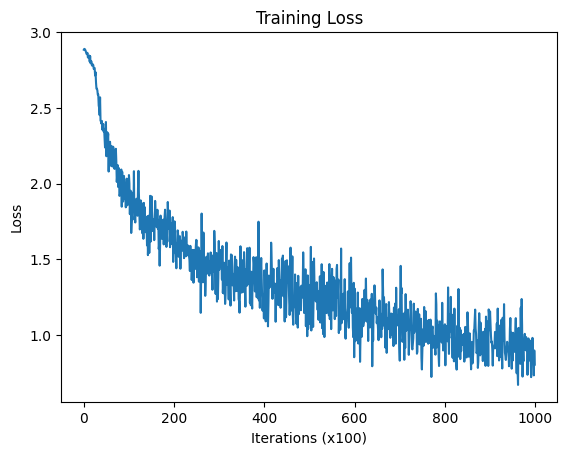

¡Entrenamiento completado!


In [7]:
# Entrenar el modelo
print("Iniciando entrenamiento...")

trained_model, data_module_train = train_rnn(
    model=model,
    data_module=data_module,
    n_iters=CONFIG['n_iters']
)

print("¡Entrenamiento completado!")

## Evaluación del modelo

Evaluamos el modelo entrenado y visualizamos los resultados.

Evaluando el modelo...
Precisión: 0.7220
Número de categorías: 18


/home/eaguayo/workspace/DeepLearning/rnn-classifier/utils/train.py:169: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + categories, rotation=90)
/home/eaguayo/workspace/DeepLearning/rnn-classifier/utils/train.py:170: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + categories)


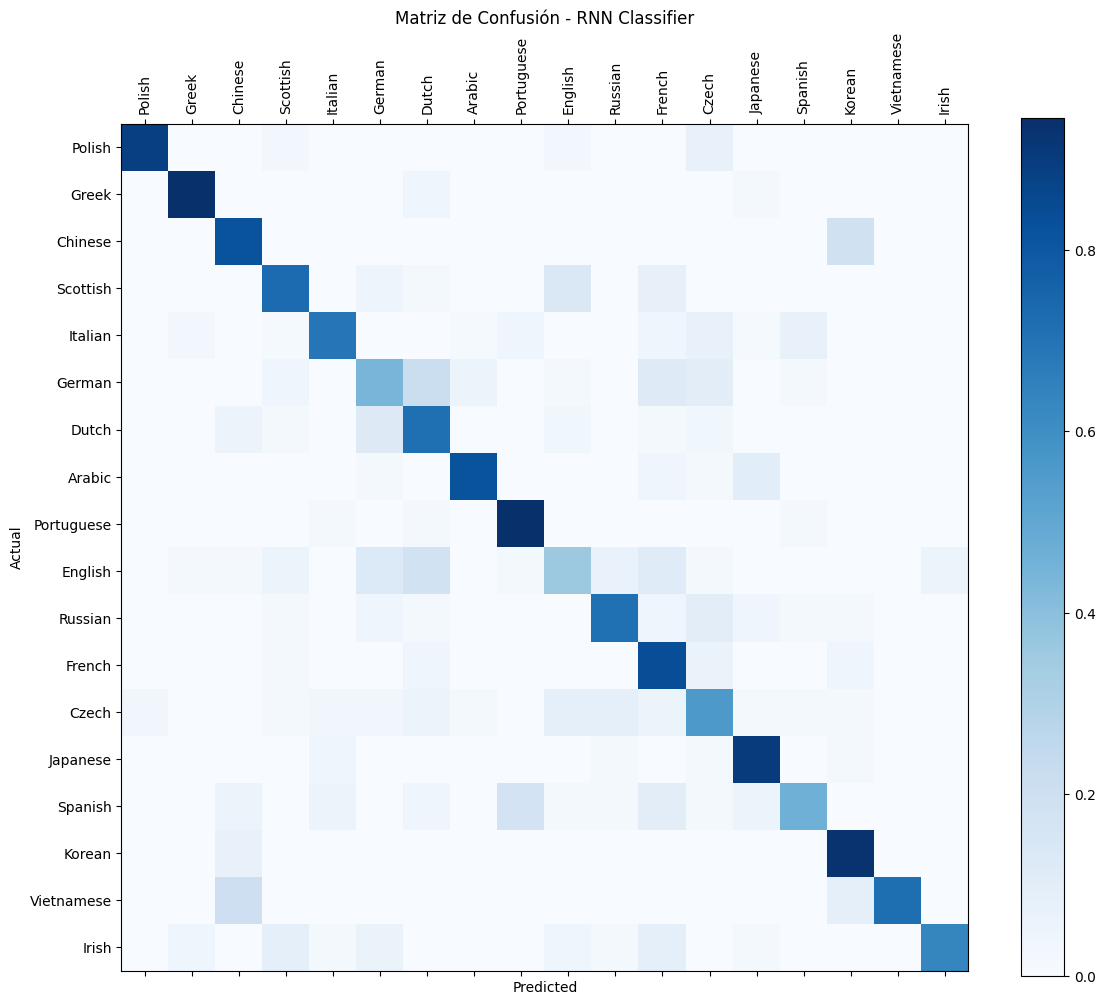

In [8]:
# Evaluar el modelo (como en el original)
print("Evaluando el modelo...")

accuracy, confusion_matrix, categories = evaluate_model(trained_model, data_module_train, n_samples=1000)

print(f"Precisión: {accuracy:.4f}")
print(f"Número de categorías: {len(categories)}")

# Visualizar matriz de confusión
plot_confusion_matrix(confusion_matrix, categories, 'Matriz de Confusión - RNN Classifier')

## Predicciones

Probamos el modelo con algunos nombres de ejemplo.

In [10]:
# Probar predicciones con nombres de ejemplo
test_names = ['Dovesky', 'Jackson', 'Satoshi', 'Rodriguez', 'Mueller', 'Li', 'Nakamura', 'Smith']

print("Predicciones del modelo:")
print("=" * 50)

for name in test_names:
    predictions = predict_name_origin(trained_model, name, categories, n_predictions=3)
    print()  # Línea en blanco entre predicciones

Predicciones del modelo:

> Dovesky
(-0.72) Czech
(-0.82) Russian
(-3.01) English


> Jackson
(-0.16) Scottish
(-2.07) English
(-4.76) Russian


> Satoshi
(-0.39) Japanese
(-1.69) Italian
(-2.68) Portuguese


> Rodriguez
(-0.48) Portuguese
(-1.54) Spanish
(-2.29) Dutch


> Mueller
(-0.76) Dutch
(-1.72) Czech
(-1.99) English


> Li
(-0.16) Vietnamese
(-2.36) Korean
(-3.03) Chinese


> Nakamura
(-0.01) Japanese
(-5.60) Portuguese
(-6.00) Arabic


> Smith
(-0.33) Scottish
(-2.19) German
(-2.92) Czech



## Conclusiones

La implementación con PyTorch Lightning ofrece las siguientes ventajas:

1. **Código más limpio y modular**: Separación clara de responsabilidades
2. **Mejor manejo de experimentos**: Logging automático y configuración fácil
3. **Escalabilidad**: Fácil adaptación a diferentes recursos de hardware
4. **Reproducibilidad**: Mejor control de semillas y configuraciones
5. **Funcionalidades avanzadas**: Early stopping, checkpointing, etc.
